In [35]:
import scipy.io
import numpy as np
import itertools
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from random import randint
import sklearn.linear_model as linear_model
import sklearn.preprocessing as prep
import math

In [36]:
## import dataset
mat = scipy.io.loadmat('SSVEPDataset.mat')
data = mat['subject'][0]
number_of_subjects = len(data)
number_of_conditions = len(data[0])
number_of_samplings = len(data[0][0])
print "Data includes", number_of_subjects, "subjects :"
print "(", number_of_conditions, "conditions per subject )"
print "(", number_of_samplings, "samplings per condition )"
#print data

Data includes 12 subjects :
( 5 conditions per subject )
( 15000 samplings per condition )


In [37]:
## select one condition data and filter out first 10-second data
#set params
condition_id =3 # ( 1 to 5 )
number_of_samplings_per_sec = 250
filtered_secs = 9
all_secs = number_of_samplings/number_of_samplings_per_sec
used_secs = all_secs - filtered_secs
number_of_filter_out_samplings = number_of_samplings_per_sec * filtered_secs
print "Parameter setting : all =", all_secs, "seconds, used = ", used_secs, "seconds" 

#get data
data_selected = np.zeros((number_of_subjects, number_of_samplings-number_of_filter_out_samplings))
for i, d in enumerate(data):
    #one loop is one subject
    join_list = list(itertools.chain.from_iterable(d[condition_id-1]))
    
    #bandpass filter
    nyq = 0.5 * number_of_samplings_per_sec
    low = 7 / nyq
    high = 8 / nyq
    order = 2
    b, a = butter(order, [low, high], btype='band')
    f = lfilter(b, a, join_list)
    
    #filter out first-ten second
    mean = np.mean(f)
    sd = np.std(f)
    data_selected[i] = [(dat-mean)/sd for dat in f[number_of_filter_out_samplings:]]

print "Select data from condition #", condition_id
print "Size of data is", len(data_selected), "subjects with", len(data_selected[0]), "samplings per subject."

Parameter setting : all = 60 seconds, used =  51 seconds
Select data from condition # 3
Size of data is 12 subjects with 12750 samplings per subject.


Each subjects contains 47 windows.
==== FFT with subjects # 0 ====


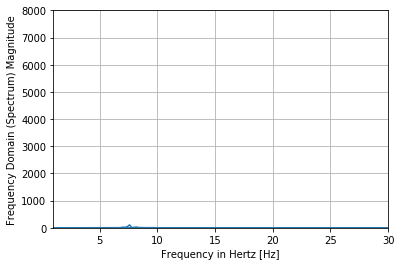

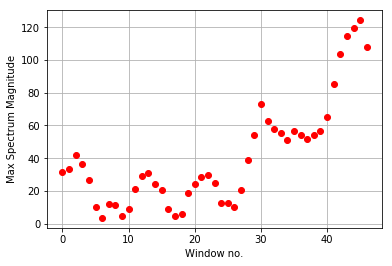

==== FFT with subjects # 1 ====


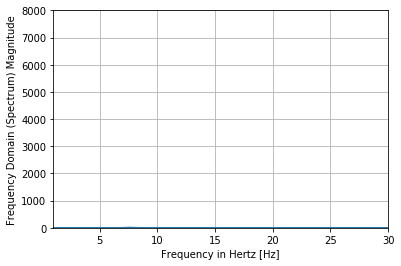

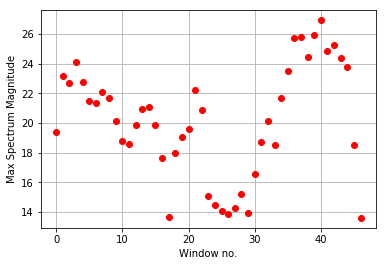

==== FFT with subjects # 2 ====


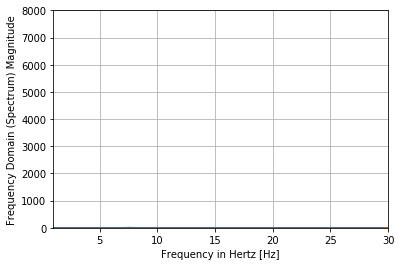

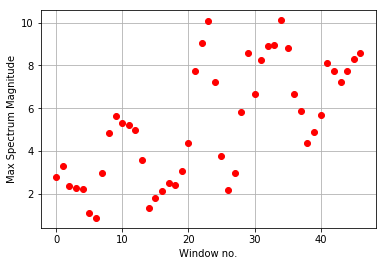

==== FFT with subjects # 3 ====


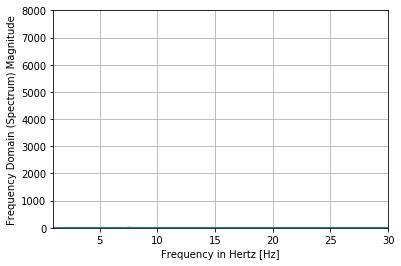

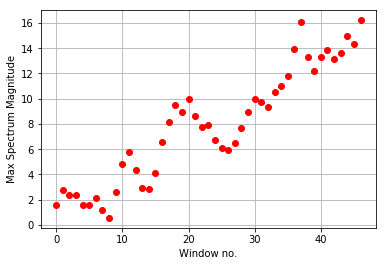

==== FFT with subjects # 4 ====


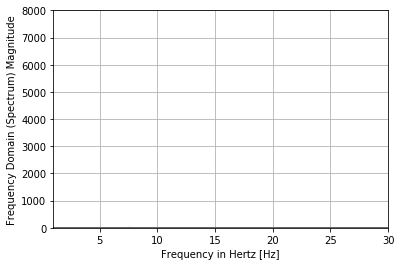

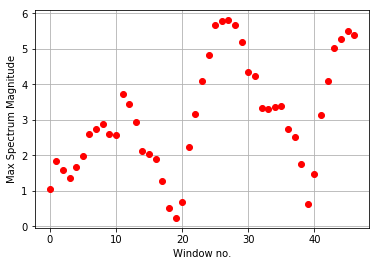

==== FFT with subjects # 5 ====


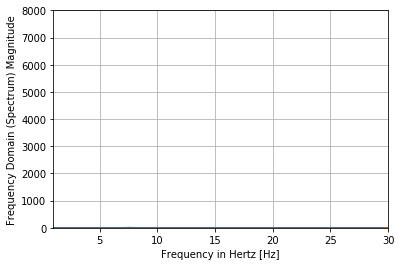

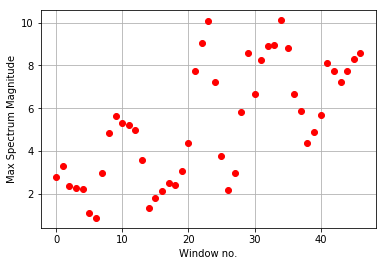

==== FFT with subjects # 6 ====


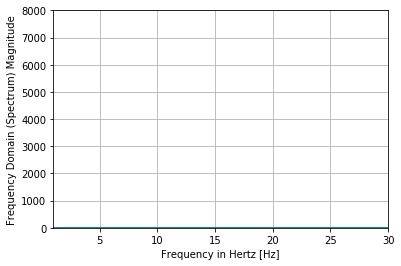

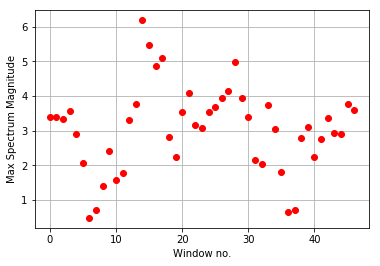

==== FFT with subjects # 7 ====


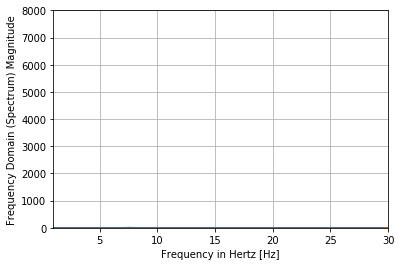

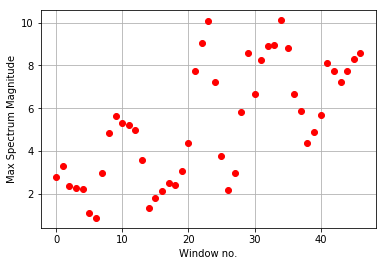

==== FFT with subjects # 8 ====


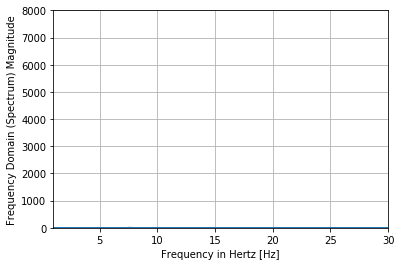

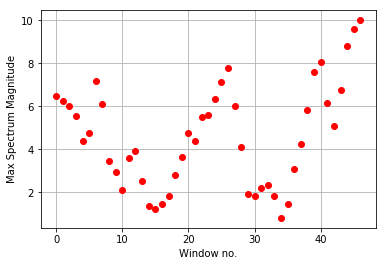

==== FFT with subjects # 9 ====


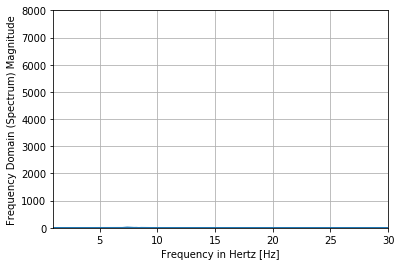

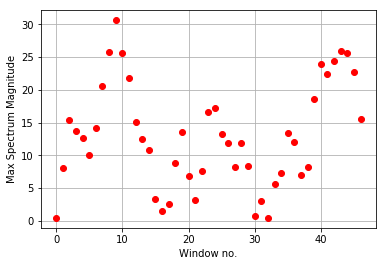

==== FFT with subjects # 10 ====


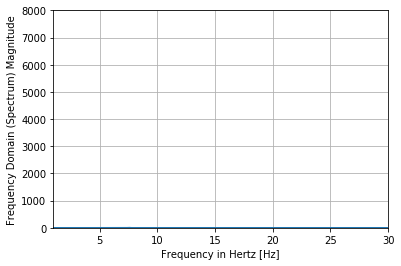

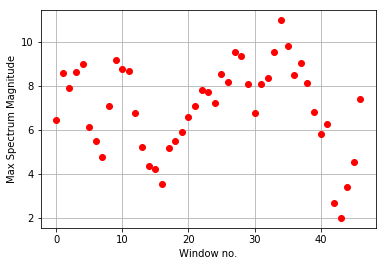

==== FFT with subjects # 11 ====


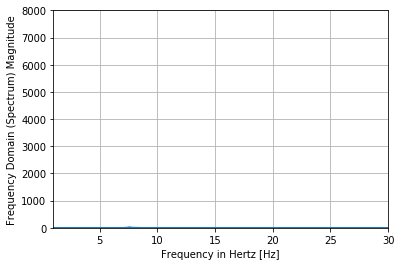

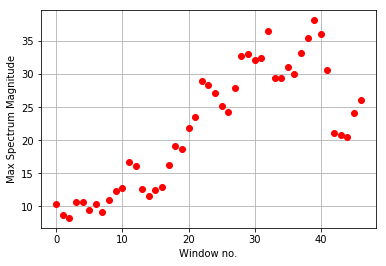

In [38]:
## perform Fast Fourier Transform (FFT)
#set params
window_size = 5 #seconds
number_of_slide_windows = used_secs-window_size+1
fft_out_max_list = np.zeros((number_of_subjects, number_of_slide_windows))
print "Each subjects contains", number_of_slide_windows, "windows."

#FFT
for i, d in enumerate(data_selected):
    print "==== FFT with subjects #", i, "===="
    for index in range(0, number_of_slide_windows):
        #print "From second #", index, "to", index+window_size-1,"( sampling no.", index*number_of_samplings_per_sec, "to", (index + window_size) * number_of_samplings_per_sec - 1, ")"
        
        #FFT with one window
        fft_out = fft(d[index*number_of_samplings_per_sec : (index + window_size) * number_of_samplings_per_sec])
        freqs = fftfreq(len(fft_out)) * number_of_samplings_per_sec
        
        #Get maximum magnitude value from window_size freq
        fft_out_max_list[i][index] = np.abs(fft_out)[np.where(freqs==7.6)]

        if index == number_of_slide_windows - 1:
            #plot FFT of some specific window
            fig, ax = plt.subplots()
            ax.plot(freqs, np.abs(fft_out))
            ax.set_xlabel('Frequency in Hertz [Hz]')
            ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
            ax.set_xlim(1, 30)
            ax.set_ylim(1, 8000)
            plt.grid()
            plt.show() 
            
    plt.plot(fft_out_max_list[i], 'ro')
    plt.xlabel('Window no.')
    plt.ylabel('Max Spectrum Magnitude')
    plt.grid()
    plt.show()
                

In [25]:
def train_test_split(x, y, test_size = 1):
    r = []
    
    while True:
        status = False
        for i in range(test_size):
            rand = 0
            while True:
                rand = randint(0, number_of_subjects-1)
                if rand not in r:
                    break
                else:
                    print rand, r
            r.append(rand)
        
        for ri in rand_indices:
            if set(ri) == set(r):
                r = []
                status = True
                break
                
        if not status:
            break
    
    print "Random result: subject #", r, "is test set."
    rand_indices.append(r)
    
    y_test = np.array([y[i] for i in r][0])
    y_train = np.array([y[i] for i in range(number_of_subjects) if i not in r])
    x_tr = np.zeros(shape = ((number_of_subjects-test_size)*number_of_slide_windows, 1))
    y_tr = np.zeros(shape = ((number_of_subjects-test_size)*number_of_slide_windows, 1))
    x_te = np.zeros(shape = (number_of_slide_windows, 1))
    y_te = np.zeros(shape = (number_of_slide_windows, 1))
    
    x_tr =x[1:number_of_subjects-test_size+1].reshape(-1,1)
    y_tr =y_train.reshape(-1,1)
    x_te =x[1:test_size+1].reshape(-1,1)
    y_te =y_test.reshape(-1,1)
        
    return x_tr, \
            x_te, \
            y_tr, \
            y_te

In [32]:
## Non-Linear Regression
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# set params
test_set_fraction = 1.0/12
test_size = 1
rand_indices = []
number_of_cv_rounds = 1
intensity_step = 3
first_light_intensity_begin = 105
last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
        ", end at intensity =", last_light_intensity_begin
print "numbers of cross validation round =", number_of_cv_rounds

# Test/train split
light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
light_intensity = np.tile(light_intensity,(number_of_subjects,1))

for i in range(0, number_of_cv_rounds):
    X_train, X_test, y_train, y_test = train_test_split(x = light_intensity, y = fft_out_max_list, test_size=test_size)
    print "X_train :", len(X_train), ", X_test :", len(X_test), ", y_train :", len(y_train), ", y_test :", len(y_test)
    print

# # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
# model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
# normalize=True,cv=5))
# model.fit(X_train,y_train)
# test_pred = np.array(model.predict(X_test))
# RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
# test_score = model.score(X_test,y_test)

Parameter settings: 1st window start at intensity = 105 , end at intensity = 246
numbers of cross validation round = 1
Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47



In [33]:
## try linear regression (not be used)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#calculate Mean Square Error
mse = np.sum(abs(y_pred-y_test)) / len(y_test)
mse

6.735559460346744

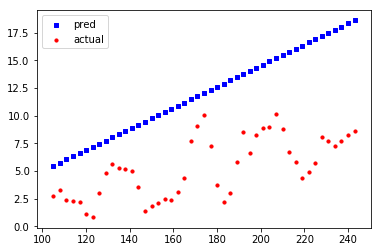

In [34]:
## plot linear regression result (not be used)
x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
plt.legend(loc='upper left');
plt.show()

In [29]:
## non-linear regression
model = prep.PolynomialFeatures(degree=3)
X_tr = model.fit_transform(X_train)
X_te = model.fit_transform(X_test)

clf = linear_model.LinearRegression()
clf.fit(X_tr, y_train)
y_pred = clf.predict(X_te)

# calculate Root Mean Square Error
rmse = math.sqrt(np.sum((y_pred-y_test)**2) / len(y_test))
rmse

7.5493859141492665

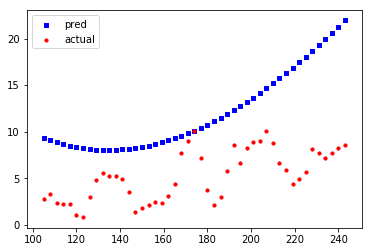

In [30]:
## plot non-linear regression result
x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
plt.legend(loc='upper left');
plt.show()

In [31]:
# from sklearn.model_selection import cross_val_predict
# from sklearn import metrics
# predicted = cross_val_predict(clf, X_tr, y_train, number_of_cv_rounds=5)
# print len(predicted)
# metrics.accuracy_score(y_test, predicted) 